In [1]:
%matplotlib inline
import math
import os 
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import matplotlib.ticker as mtick
from matplotlib.gridspec import GridSpec
import statsmodels.api as sm
from pandas import ExcelWriter
import pickle
import scipy as sp

In [2]:
def load_object(filename):
    with open(filename, 'rb') as fid:
        file = pickle.load(fid)
    return file

def index(data, label):
    mini = data.reset_index()[data.reset_index()['labels'] == label].index.min()
    maxi = data.reset_index()[data.reset_index()['labels'] == label].index.max()
    return [mini,maxi]

def non_zero_data(data):
    #data = data.drop(columns = "ID")
    non_zero_rows = data.abs().sum(axis=1) > 0.0
    non_zero_data = data[non_zero_rows]
    #non_zero_columns = non_zero_data.abs().sum(axis=0) > 0.0
    #non_zero_data = non_zero_data.loc[: , non_zero_columns]
    return non_zero_data

#put multiple DFs together with the key
def combineddf(dflist, dfkeys, ELEMENTS, noise = None, coefficient = None,):
    #make an empty list
    combinedlist = []
    #make an empty dataframe
    combineddf12 = pd.DataFrame()

    for i,j in zip(dflist, dfkeys):
        if noise == None and coefficient == None:
            df = non_zero_data(i[ELEMENTS])
            #fillnan with 0
            df[np.isnan(df)] = 0
        else:
            #add noise
            df = addnoise(i[ELEMENTS], noise, coefficient)


        df['labels'] = j
        combinedlist.append(df)
        combineddf12 = pd.concat([combineddf12, df])
    return combineddf12

ELEMENTS = ['48Ti', '53Cr', '55Mn', '54Fe', '59Co', '60Ni', '63Cu', '64Zn', '69Ga', '72Ge', '75As', '78Se', '85Rb', '88Sr', '89Y', '90Zr', '93Nb', 
           '98Mo', '108Pd', '107Ag', '114Cd', '120Sn', '121Sb', '133Cs', '138Ba', '139La', '140Ce', '152Sm', '153Eu', '158Gd', '159Tb', '164Dy', '165Ho',
           '166Er', '169Tm', '174Yb', '175Lu', '180Hf', '185Re', '192Os', '193Ir', '195Pt', '197Au', '202Hg', '208Pb', '238U', '51V']

In [3]:

#returns aggregate particles of a dataset
def aggregate_particles(data, element1 = None):
    total = []
    #go through each row
    for i in data.itertuples():
        labels = []
        #in that row, go through each element
        for j in range(1, len(i)):
            #if there is some value
            if i[j] > 0:
                #append the element into the labels list
                labels.append(data.columns[j - 1])
                #if there is no elements
                if labels[-1] == None:
                    print('ERROR')
        #if there are some elements in the labels list
        if labels != []:
            #append it to the total list
            total.append(labels)
    #make an array of this
    total = np.array(total)
    #only find the unique labels
    uniquelist = np.unique(total)
    
    
    #if element1 is there, focus on that one element
    if element1 != None:
        uniquelist = uniquelist[[element1 in i for i in uniquelist]]
        
    uniquelist1 = []
    #for each unique label
    for i in uniquelist:
        #join them together with a + sign
        uniquelist1.append('+'.join(i))
    totalvalue = []
    # for each unique label
    for i in uniquelist:
        value = 0
        # for each label in total
        for j in total:
            if i == j:
                #count how many there are
                value = value + 1
        totalvalue.append(value)

    finaldf = pd.DataFrame(totalvalue, uniquelist1, columns = ['Value']).sort_values('Value', ascending = False)
    return finaldf

    #returns aggregate particles of a dataset
def aggregate_particles_mod(data):
    total = []
    #go through each row
    for i in data.itertuples():
        labels = []
        #in that row, go through each element
        for j in range(1, len(i)):
            #if there is some value
            if i[j] > 0:
                #append the element into the labels list
                labels.append(data.columns[j - 1])
                #if there is no elements
                if labels[-1] == None:
                    print('ERROR')
        #if there are some elements in the labels list
        if labels != []:
            #append it to the total list
            total.append('+'.join(labels))
    #make an array of this
    total = np.array(total)
    #only find the unique labels
    uniquelist = np.unique(total)
    return total

#returns aggregate particles of a dataset
def aggregate_particles_specific(data, element1 = None):
    total = []
    #go through each row
    for i in data.itertuples():
        labels = []
        #in that row, go through each element
        for j in range(1, len(i)):
            #if there is some value
            if i[j] > 0:
                #append the element into the labels list
                labels.append(data.columns[j - 1])
                #if there is no elements
                if labels[-1] == None:
                    print('ERROR')
        #if there are some elements in the labels list
        if labels != []:
            #append it to the total list
            total.append(labels)
    #make an array of this
    total = np.array(total)
    #only find the unique labels
    uniquelist = np.unique(total)
    
    
    #if element1 is there, focus on that one element
    if element1 != None:
        uniquelist = uniquelist[[element1 in i for i in uniquelist]]
        
    uniquelist1 = []
    #for each unique label
    for i in uniquelist:
        #join them together with a + sign
        uniquelist1.append('+'.join(i))
    totalvalue = []
    # for each unique label
    for i in uniquelist:
        value = 0
        # for each label in total
        for j in total:
            if i == j:
                #count how many there are
                value = value + 1
        totalvalue.append(value)

    finaldf = pd.DataFrame(totalvalue, uniquelist1, columns = ['Value']).sort_values('Value', ascending = False).reset_index()
    return finaldf, total

#Type: Data Frame. From a selected isotope and its particle events, select all other isotopes associated and drop others not associated with it
def isotope_particle(data, isotope):
    obs = data[data[isotope]>0.0]
    return obs

In [4]:
#load the codes
Qian2016codes = load_object('models/multipleLDAmodels/Qian2016codes_5.pkl')
Qian2018codes = load_object('models/multipleLDAmodels/Qian2018codes_5.pkl')
QianU2019codes = load_object('models/multipleLDAmodels/QianU2019codes_5.pkl')
QianR2019codes = load_object('models/multipleLDAmodels/QianR2019codes_5.pkl')
Sourcetrainingcodes = load_object('models/multipleLDAmodels/Sourcesamples_trainingcodes_5.pkl')
Sourcetestingcodes = load_object('models/multipleLDAmodels/Sourcesamples_testingcodes_5.pkl')

Qian2016, Qian2016keys = load_object('models/multipleLDAmodels/Qian2016DF_5.pkl')
Qian2018, Qian2018keys = load_object('models/multipleLDAmodels/Qian2018DF_5.pkl')
QianU2019, QianU2019keys = load_object('models/multipleLDAmodels/QianU2019DF_5.pkl')
QianR2019, QianR2019keys = load_object('models/multipleLDAmodels/QianR2019DF_5.pkl')
Sourcetraining, Sourcekeys = load_object('models/multipleLDAmodels/SourcetrainingDF_5.pkl')
Sourcetesting, Sourcekeys = load_object('models/multipleLDAmodels/SourcetestingDF_5.pkl')

#load mapping feature
m = load_object('models/multipleLDAmodels/randommappingfeature.pkl')

# choose the best model and apply on samples

In [5]:
#try alpha = 0.01 and number of clusters = 10

#fit the Sourcecodes_training
from sklearn.decomposition import LatentDirichletAllocation

model2 = LatentDirichletAllocation(n_components=10, doc_topic_prior = 0.01)

In [6]:
model2 = model2.fit(Sourcetrainingcodes)

Qian2016prob = model2.transform(Qian2016codes)
maxprob = Qian2016prob.max(axis = 1)
clustermax = Qian2016prob.argmax(axis = 1)

Sourceprob = model2.transform(Sourcetrainingcodes)
Sourcemaxprob = Sourceprob.max(axis = 1)
Sourceclustermax = Sourceprob.argmax(axis = 1)

Sourcetestingprob = model2.transform(Sourcetestingcodes)
Sourcetestingmaxprob = Sourcetestingprob.max(axis = 1)
Sourcetestingclustermax = Sourcetestingprob.argmax(axis = 1)

In [7]:
#save object
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

In [8]:
save_object(model2, 'models/multipleLDAmodels/LDAModel.pkl')

# combine dataframe

In [9]:
Sourcetesting = combineddf(Sourcetesting, Sourcekeys, ELEMENTS)
Sourcetesting['elements'] = aggregate_particles_mod(Sourcetesting[ELEMENTS])
Sourcetesting['cluster'] = Sourcetestingprob.argmax(axis = 1)
Sourcetesting['max prob'] = Sourcetestingprob.max(axis = 1)

In [10]:
Sourcetraining = combineddf(Sourcetraining, Sourcekeys, ELEMENTS)
Sourcetraining.reset_index(drop = True, inplace = True)
Sourcetraining['elements'] = aggregate_particles_mod(Sourcetraining[ELEMENTS])
Sourcetraining['cluster'] = Sourceprob.argmax(axis = 1)
Sourcetraining['max prob'] = Sourceprob.max(axis = 1)

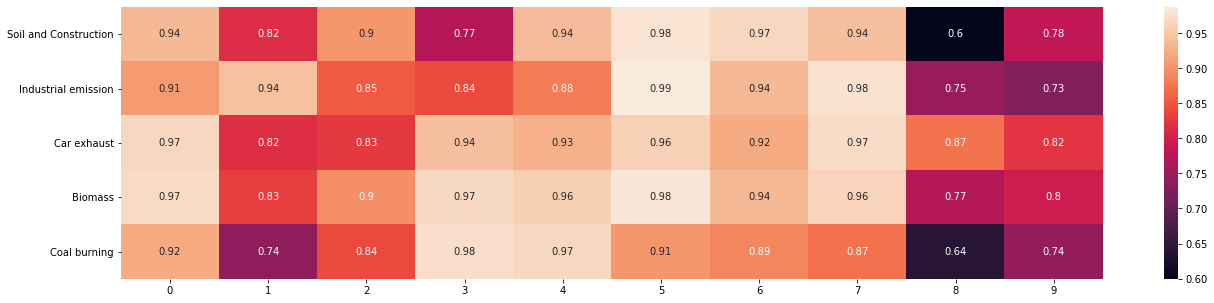

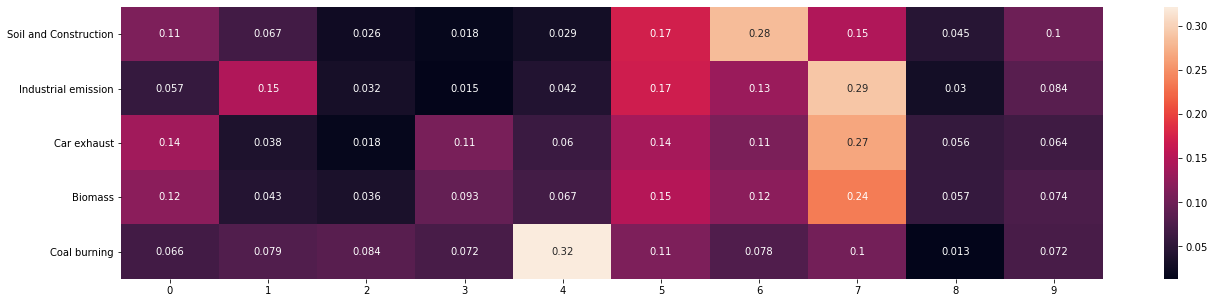

In [30]:
Sourceprob = model2.transform(Sourcetrainingcodes)
    
soilconconf = np.zeros(Sourceprob[index(Sourcetraining, 'Soil and Construction')[0]: index(Sourcetraining, 'Soil and Construction')[1]].shape)
indemissionconf = np.zeros(Sourceprob[index(Sourcetraining, 'Industrial emission')[0]: index(Sourcetraining, 'Industrial emission')[1]].shape)
carexhaustconf = np.zeros(Sourceprob[index(Sourcetraining, 'Car exhaust')[0]: index(Sourcetraining, 'Car exhaust')[1]].shape)
biomassconf = np.zeros(Sourceprob[index(Sourcetraining, 'Biomass')[0]: index(Sourcetraining, 'Biomass')[1]].shape)
coalburningconf = np.zeros(Sourceprob[index(Sourcetraining, 'Coal burning')[0]: index(Sourcetraining, 'Coal burning')[1]].shape)

indexconf = ['Soil and Construction', 'Industrial emission', 'Car exhaust', 'Biomass', 'Coal burning']
conflist = [soilconconf, indemissionconf, carexhaustconf, biomassconf, coalburningconf]

for indexm, matrix in zip(indexconf, conflist):
    #print(indexm)
    intermediateargmax = Sourceprob[index(Sourcetraining, indexm)[0]: index(Sourcetraining, indexm)[1]].argmax(axis=1)
    intermediatemax = Sourceprob[index(Sourcetraining, indexm)[0]: index(Sourcetraining, indexm)[1]].max(axis=1)
    for i in np.arange(0, len(matrix)):
        matrix[i, intermediateargmax[i]] = intermediatemax[i]

    #find the average and the count for every component
confcountcomb = np.zeros([5, 10])
confavgcomb = np.zeros([5, 10])
for ind, conf in enumerate(conflist):
    confcount = np.zeros([1,10])
    for inds in np.arange(0, 10):
        confcount[:,inds] = len(conf[:,inds][np.nonzero(conf[:,inds])])/len(conf)

    confaverage = np.zeros([1,10])
    for inds in np.arange(0, 10):
        confaverage[:,inds] = np.average(conf[:,inds][np.nonzero(conf[:,inds])])
    confcountcomb[ind] = confcount
    confavgcomb[ind] = confaverage

fig = plt.figure(figsize = (22,5))
sns.heatmap(pd.DataFrame(confavgcomb, index = indexconf), annot = True)
plt.savefig('Figures/heatmapprobscluster.png', dpi = 300)

fig = plt.figure(figsize = (22,5))
sns.heatmap(pd.DataFrame(confcountcomb, index = indexconf), annot = True)
plt.savefig('Figures/heatmapcountscluster.png', dpi = 300)

# Get the unique matrix for the cluster for each source

In [12]:
from sklearn.neighbors import KNeighborsClassifier
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle

def sourceclustermax(sampledf, ELEMENTS, sourcedf):

    totaldf = pd.DataFrame()
    y_scoredf = pd.DataFrame()
    Binarytestlabelsdf = pd.DataFrame()

    for cluster in np.arange(0,10):
        #all particles that is the first sample and the first cluster
        train = sourcedf[sourcedf['cluster'] == cluster]
        test = sampledf[sampledf['cluster'] == cluster]

        totaldf1 = pd.DataFrame()
        y_scoredf1 = pd.DataFrame()
        Binarytestlabelsdf1 = pd.DataFrame()

        #get the elements column in dataframe
        for particle in test['elements'].unique():
            trainingdf = train[train['elements'] == particle]
            testingdf = test[test['elements'] == particle]
            model = KNeighborsClassifier(n_neighbors = int(math.ceil(0.2*len(trainingdf))), weights = 'distance')
            Binarymodel = OneVsRestClassifier(model)
            try:
                model.fit(trainingdf[ELEMENTS], trainingdf['labels'])
                testingdf.loc[:,'Probable Source'] = model.predict(testingdf[ELEMENTS])

                BinaryTrainlabels = label_binarize(trainingdf['labels'], classes = Sourcekeys)
                BinaryTestlabels = label_binarize(testingdf['labels'], classes = Sourcekeys)
                Binarymodel.fit(trainingdf[ELEMENTS], BinaryTrainlabels)
                y_score = Binarymodel.predict_proba(testingdf[ELEMENTS])
            except:
                testingdf.loc[:,'Probable Source'] = 'Uncertain'

            totaldf1 = pd.concat([totaldf1, testingdf])
            Binarytestlabelsdf1 = pd.concat([Binarytestlabelsdf1, pd.DataFrame(BinaryTestlabels)])
            y_scoredf1 = pd.concat([y_scoredf1, pd.DataFrame(y_score)])

        totaldf = pd.concat([totaldf,  totaldf1])
        Binarytestlabelsdf = pd.concat([Binarytestlabelsdf, Binarytestlabelsdf1])
        y_scoredf = pd.concat([y_scoredf, y_scoredf1])

    return totaldf, y_scoredf, Binarytestlabelsdf

In [13]:
Sourcetestingtotaldf, yscoredftest, Btest1 = sourceclustermax(Sourcetesting, ELEMENTS, Sourcetraining)
Sourcetrainingtotaldf, scoredftrain, Btrain1 = sourceclustermax(Sourcetraining, ELEMENTS, Sourcetraining)

C:\Users\Garret Bland\anaconda3\envs\TOF Classification\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\Garret Bland\anaconda3\envs\TOF Classification\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\Garret Bland\anaconda3\envs\TOF Classification\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is t

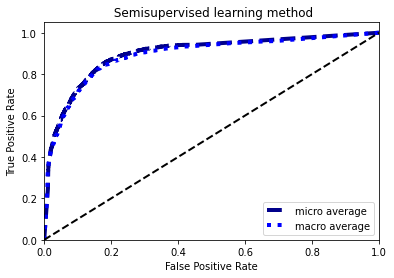

In [14]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(Sourcekeys)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Btest1.loc[:, i], yscoredftest.loc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(np.array(Btest1).ravel(), np.array(yscoredftest).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
df =  pd.DataFrame(index = roc_auc.keys(), data = roc_auc.values())

# Plot all ROC curves
plt.plot(fpr["micro"], tpr["micro"], label = 'micro average', linestyle='--', linewidth=4, color = 'darkblue')

plt.plot(fpr["macro"], tpr["macro"], label = 'macro average', linestyle=':', linewidth=4, color = 'blue')

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')
plt.title(' Semisupervised learning method')
plt.legend(loc="lower right")
plt.savefig('Figures/ROCcurvesemisupervised.png', dpi = 300)

In [15]:
#testing error
len(Sourcetestingtotaldf[Sourcetestingtotaldf['labels'] == Sourcetestingtotaldf['Probable Source']])/len(Sourcetestingtotaldf)

0.6124105011933174

In [16]:
#testing error
len(Sourcetrainingtotaldf[Sourcetrainingtotaldf['labels'] == Sourcetrainingtotaldf['Probable Source']])/len(Sourcetrainingtotaldf)

1.0

In [17]:
#isolate to 55Mn + 54Fe
exampledf = Sourcetesting[Sourcetesting['elements'] == '55Mn+54Fe']
exampletrainingdf = Sourcetraining[Sourcetraining['elements'] == '55Mn+54Fe']
exampledf, nothing, nothing2 = sourceclustermax(exampledf, ELEMENTS, exampletrainingdf)

In [18]:
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import ListedColormap
# Create color maps
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue', 'red', 'magenta'])
cmap_bold = ['darkorange', 'c', 'darkblue', 'crimson', 'magenta']


TrainLabels = LabelEncoder().fit(Sourcekeys).transform(exampletrainingdf['labels'])
model = KNeighborsClassifier(n_neighbors = int(math.ceil(0.2*len(exampletrainingdf))), weights = 'distance')
model.fit(exampletrainingdf[['54Fe', '55Mn']] , TrainLabels)
h = 0.02*10**-14

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = exampledf['54Fe'].min() - 10**-14, exampledf['54Fe'].max() + 2*10**-14
y_min, y_max = exampledf['55Mn'].min() - 10**-14,  exampledf['55Mn'].max() + 10**-14
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

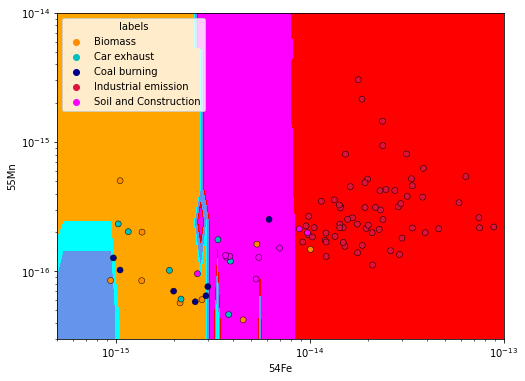

In [19]:
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap = cmap_light)

# Plot also the training points
sns.scatterplot(x=exampledf.sort_values('labels')['54Fe'], y=exampledf.sort_values('labels')['55Mn'], hue=exampledf.sort_values('labels')['labels'], palette = cmap_bold, alpha=1.0, edgecolor="black")
plt.xlim(5*10**-16, 10**-13)
plt.ylim(3*10**-17, 10**-14)
plt.xscale('log')
plt.yscale('log')

plt.savefig('Figures/KNNMnFeexample.png', dpi = 300)

# Creating figures

In [20]:
def percSource(totaldf, samplekeys):
    Sourceallocation = []
    for key in samplekeys:
        alloc = np.unique(totaldf[totaldf['labels'] == key]['Probable Source'], return_counts = True)
        perc = alloc[1]/alloc[1].sum()
        Sourceallocation.append([alloc[0], perc, alloc[1]])
    return Sourceallocation

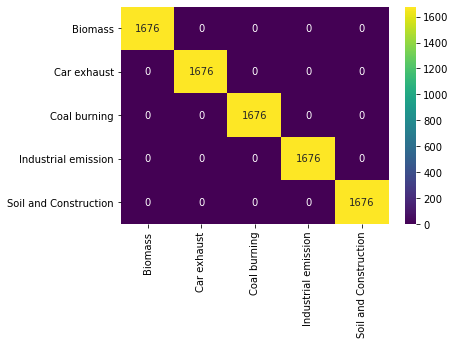

In [21]:
Sourceallocationdf = pd.DataFrame()
for i in percSource(Sourcetrainingtotaldf, Sourcekeys):
    Sourceallocationdf = pd.concat([Sourceallocationdf,  pd.DataFrame(i[2], index = i[0])], axis = 1)
Sourceallocationdf.columns = Sourcekeys
Sourceallocationdf.fillna(0, inplace= True)
Sourceallocationdf = Sourceallocationdf.astype('int').sort_index()

#Sourceallocationdf
cols = Sourceallocationdf.columns.tolist()
cols = ['Biomass', 'Car exhaust', 'Coal burning', 'Industrial emission', 'Soil and Construction']
Sourceallocationdf = Sourceallocationdf[cols]

sns.heatmap(Sourceallocationdf.T, annot = True, fmt="d", cmap = 'viridis')
plt.savefig('Figures/confusionmatrixsemisupervisedmethodtrain.png', dpi = 300)

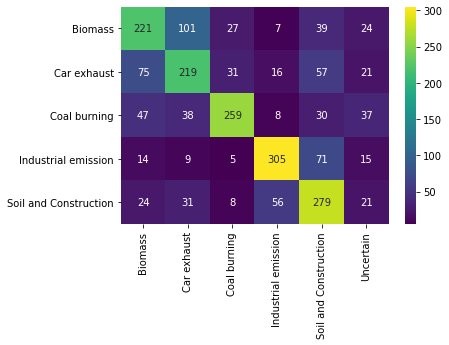

In [22]:
Sourceallocationdf = pd.DataFrame()
for i in percSource(Sourcetestingtotaldf, Sourcekeys):
    Sourceallocationdf = pd.concat([Sourceallocationdf,  pd.DataFrame(i[2], index = i[0])], axis = 1)
Sourceallocationdf.columns = Sourcekeys

#Sourceallocationdf
cols = Sourceallocationdf.columns.tolist()
cols = ['Biomass', 'Car exhaust', 'Coal burning', 'Industrial emission', 'Soil and Construction']
Sourceallocationdf = Sourceallocationdf[cols]

sns.heatmap(Sourceallocationdf.T, annot = True, fmt="d", cmap = 'viridis')
plt.savefig('Figures/confusionmatrixsemisupervisedmethodtest.png', dpi = 300)

In [23]:
metalcomposition = pd.DataFrame()
for i in Sourcekeys:
    df = Sourcetraining[Sourcetraining['labels'] == i]
    singlemetal = df[df['elements'].str.len() <= 5]
    multimetal = df[df['elements'].str.len()  >= 6]
    metalcomposition = pd.concat([metalcomposition, pd.DataFrame([len(singlemetal), len(multimetal)], index = ['Single Element', 'Multi Element'])], axis = 1)
metalcomposition.columns = Sourcekeys

<ipython-input-24-78df6a6c0107>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(metalcomposition.columns, rotation =  45)


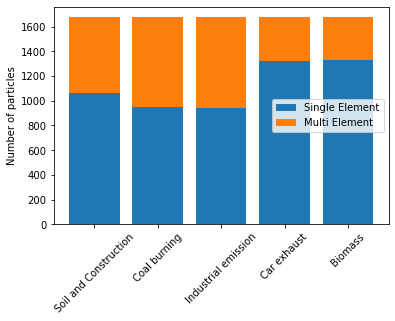

In [24]:
fig, ax = plt.subplots()
ax.bar(metalcomposition.columns, metalcomposition.T['Single Element'], label = 'Single Element')
ax.bar(metalcomposition.columns, metalcomposition.T['Multi Element'], bottom = metalcomposition.T['Single Element'], label = 'Multi Element')
ax.set_xticklabels(metalcomposition.columns, rotation =  45)
ax.set_ylabel('Number of particles')
plt.legend(loc = 'right')
plt.savefig('Figures/elementcomposition.png', dpi = 300)

## Misclassification

In [25]:
misclassification = []
for i in Sourcekeys:
    df = Sourcetestingtotaldf[Sourcetestingtotaldf['labels'] == i]
    df1 = df[df['Probable Source'] != i]
    misclassification.append(aggregate_particles(df1[ELEMENTS]))

<ipython-input-3-e9620662e320>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  total = np.array(total)


In [26]:
writer = ExcelWriter('outputdata/misclassification.xlsx', engine = 'xlsxwriter')
for i,j in enumerate(misclassification):
    j.to_excel(writer, sheet_name = Sourcekeys[i])
writer.save()

# Get the frequency

In [27]:
allmatrices = []
for cluster in np.arange(0,10):
    #get the uniquematrix for each source
    uniquematrix = []
    for i in Sourcekeys:
        df = Sourcetraining[Sourcetraining['cluster'] == cluster]
        df1 = df[df['labels'] == i]
        uniquematrix.append(aggregate_particles_specific(df1[ELEMENTS])[0])
    allmatrices.append(uniquematrix)

uniquematrixDF = pd.DataFrame()
for dataframelist in allmatrices:
    uniquematrixlistDF = pd.DataFrame()
    for dataframe in dataframelist:
        uniquematrixlistDF = pd.concat([uniquematrixlistDF, dataframe.set_index('index')], axis = 1)
    uniquematrixlistDF.columns = Sourcekeys
    #concat all the particles data together
    uniquematrixDF = pd.concat([uniquematrixDF, uniquematrixlistDF])

# sort by the length of elements. 
uniquematrixDF = uniquematrixDF.sort_index(key=lambda x: x.str.len())

# get 1 element
sourcemax = []
for i in uniquematrixDF.loc[uniquematrixDF.index.str.len() <= 5].iterrows():
    sourcemax.append(Sourcekeys[i[1].argmax()])
df = pd.concat([uniquematrixDF.loc[uniquematrixDF.index.str.len() <= 5], 
    pd.DataFrame(sourcemax, index = uniquematrixDF.loc[uniquematrixDF.index.str.len() <= 5].index)], axis = 1)

df.to_excel('outputdata/unique_matrix.xlsx')

# get 2 elements
highermarg = uniquematrixDF.loc[uniquematrixDF.index.str.len() >= 6]
lowermarg = highermarg.loc[highermarg.index.str.len() <= 11]
sourcemax = []
for i in lowermarg.iterrows():
    sourcemax.append(Sourcekeys[i[1].argmax()])
lowermarg = pd.concat([lowermarg, pd.DataFrame(sourcemax, index = lowermarg.index)], axis = 1)
lowermarg.to_excel('outputdata/unique_matrix2elements.xlsx')

# 3 or more elmeents
df = uniquematrixDF.loc[uniquematrixDF.index.str.len() >= 12]
sourcemax = []
for i in df.iterrows():
    sourcemax.append(Sourcekeys[i[1].argmax()])
df = pd.concat([df, pd.DataFrame(sourcemax, index = df.index)], axis = 1)
df.to_excel('outputdata/unique_matrix3moreelements.xlsx')


<ipython-input-3-e9620662e320>:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  total = np.array(total)
<ipython-input-3-e9620662e320>:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  total = np.array(total)
<ipython-input-3-e9620662e320>:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  total = np.array(total)
<ipython-input-3-e9

# Isotope distribution

In [28]:
# Get the top 10 elements for each cluster
isotope_matrix = model2.components_ @ np.transpose(m)
isotope_DF = pd.DataFrame(isotope_matrix, columns = ELEMENTS)

rankedelements = []
for i in isotope_DF.T.columns:
    rankedelements.append(isotope_DF.T[i].sort_values(ascending = False)[0:10].index.values)

pd.DataFrame(rankedelements).to_excel('outputdata/rankedelements.xlsx')